# Synthetic data backtesting example

This is an example notebook how to create and run backtests with
`tradeexecutor` framework.

Some highlights of this notebook:

* Runs everything within a single notebook
    - The backtest code and charts are self-contained in a single file
    - The example code is easy to read
    - Easy to test different functionalities of `tradeexecutor` library
* Uses generated, synthetic, random price data
    - Notebook runs offline
    - No downloads needed
    - No API keys needed
    - Running the notebook completes quickly, making it suitable for low powered devices and demos

## Set up

Set up strategy paramets that will decide its behavior

In [1]:
import datetime
import logging

import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.strategy_module import TradeRouting, ReserveCurrency

trading_strategy_cycle = CycleDuration.cycle_1d

# Strategy keeps its cash in BUSD
reserve_currency = ReserveCurrency.busd

# How much of the cash to put on a single trade
position_size = 0.10

#
# Strategy thinking specific parameter
#

slow_ema_candle_count = 20

fast_ema_candle_count = 5

# How many candles to extract from the dataset once
batch_size = 90

# Range of backtesting and synthetic data generation.
# Because we are using synthetic data actual dates do not really matter -
# only the duration

start_at = datetime.datetime(2021, 6, 1)
start_at_data = datetime.datetime(2021, 1, 1)
end_at = datetime.datetime(2022, 1, 1)


## Strategy logic and trade decisions

`decide_trades` function decide what trades to take.
In this example, we calculate two exponential moving averages
(EMAs) and make decisions based on those.

In [2]:
from typing import List, Dict
from pandas_ta.overlap import ema
from tradingstrategy.universe import Universe

from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pricing_model import PricingModel
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradeexecutor.state.state import State



def decide_trades(
        timestamp: pd.Timestamp,
        universe: Universe,
        state: State,
        pricing_model: PricingModel,
        cycle_debug_data: Dict) -> List[TradeExecution]:
    """The brain function to decide the trades on each trading strategy cycle."""

    # The pair we are trading
    pair = universe.pairs.get_single()

    # How much cash we have in the hand
    cash = state.portfolio.get_current_cash()

    # Get OHLCV candles for our trading pair as Pandas Dataframe.
    # We could have candles for multiple trading pairs in a different strategy,
    # but this strategy only operates on single pair candle.
    # We also limit our sample size to N latest candles to speed up calculations.
    candles: pd.DataFrame = universe.candles.get_single_pair_data(timestamp, sample_count=batch_size)

    # We have data for open, high, close, etc.
    # We only operate using candle close values in this strategy.
    close = candles["close"]

    # Calculate exponential moving averages based on slow and fast sample numbers.
    # https://github.com/twopirllc/pandas-ta
    # https://github.com/twopirllc/pandas-ta/blob/bc3b292bf1cc1d5f2aba50bb750a75209d655b37/pandas_ta/overlap/ema.py#L7
    slow_ema_series = ema(close, length=slow_ema_candle_count)
    fast_ema_series = ema(close, length=fast_ema_candle_count)

    if slow_ema_series is None or fast_ema_series is None:
        # Cannot calculate EMA, because
        # not enough samples in backtesting
        return []

    slow_ema = slow_ema_series.iloc[-1]
    fast_ema = fast_ema_series.iloc[-1]

    # Get the last close price from close time series
    # that's Pandas's Series object
    # https://pandas.pydata.org/docs/reference/api/pandas.Series.iat.html
    current_price = close.iloc[-1]

    # List of any trades we decide on this cycle.
    # Because the strategy is simple, there can be
    # only zero (do nothing) or 1 (open or close) trades
    # decides
    trades = []

    # Create a position manager helper class that allows us easily to create
    # opening/closing trades for different positions
    position_manager = PositionManager(timestamp, universe, state, pricing_model)

    if not position_manager.is_any_open():
        
        if current_price >= slow_ema:
        # Entry condition:
        # Close price is higher than the slow EMA
            buy_amount = cash * position_size
            trades += position_manager.open_1x_long(pair, buy_amount)
    else:
        
        if fast_ema >= slow_ema:
        # Exit condition:
        # Fast EMA crosses slow EMA
            trades += position_manager.close_all()

    # Visualize strategy
    # See available Plotly colours here
    # https://community.plotly.com/t/plotly-colours-list/11730/3?u=miohtama
    visualisation = state.visualisation
    visualisation.plot_indicator(timestamp, "Slow EMA", PlotKind.technical_indicator_on_price, slow_ema, colour="darkblue")
    visualisation.plot_indicator(timestamp, "Fast EMA", PlotKind.technical_indicator_on_price, fast_ema, colour="#003300")

    return trades

## Defining trading universe

We create a trading universe with a single blockchain, exchange and trading pair.
For the sake of easier understanding the code, we name this "Uniswap v2" like exchange with a single ETH-USDC trading pair.

The trading pair contains generated noise-like OHLCV trading data.

In [3]:

import random
from tradeexecutor.state.identifier import AssetIdentifier, TradingPairIdentifier
from tradingstrategy.candle import GroupedCandleUniverse
from tradeexecutor.testing.synthetic_ethereum_data import generate_random_ethereum_address
from tradeexecutor.testing.synthetic_exchange_data import generate_exchange
from tradeexecutor.testing.synthetic_price_data import generate_ohlcv_candles
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, \
    create_pair_universe_from_code

def create_trading_universe() -> TradingStrategyUniverse:

    # Set up fake assets
    mock_chain_id = ChainId.ethereum
    mock_exchange = generate_exchange(
        exchange_id=random.randint(1, 1000),
        chain_id=mock_chain_id,
        address=generate_random_ethereum_address())
    usdc = AssetIdentifier(ChainId.ethereum.value, generate_random_ethereum_address(), "USDC", 6, 1)
    weth = AssetIdentifier(ChainId.ethereum.value, generate_random_ethereum_address(), "WETH", 18, 2)
    weth_usdc = TradingPairIdentifier(
        weth,
        usdc,
        generate_random_ethereum_address(),
        mock_exchange.address,
        internal_id=random.randint(1, 1000),
        internal_exchange_id=mock_exchange.exchange_id,
        fee=0.0005
    )

    time_bucket = TimeBucket.d1

    pair_universe = create_pair_universe_from_code(mock_chain_id, [weth_usdc])

    candles = generate_ohlcv_candles(time_bucket, start_at_data, end_at, pair_id=weth_usdc.internal_id)
    candle_universe = GroupedCandleUniverse.create_from_single_pair_dataframe(candles)

    universe = Universe(
        time_bucket=time_bucket,
        chains={mock_chain_id},
        exchanges={mock_exchange},
        pairs=pair_universe,
        candles=candle_universe,
        liquidity=None
    )

    return TradingStrategyUniverse(universe=universe, reserve_assets=[usdc])



## Running the backtest

Run backtest using giving trading universe and strategy function.

Running the backtest outputs `state` object that contains all the information
on the backtesting position and trades.

In [4]:
from tradeexecutor.testing.synthetic_exchange_data import generate_simple_routing_model
from tradeexecutor.backtest.backtest_runner import run_backtest_inline

universe = create_trading_universe()

start_candle, end_candle = universe.universe.candles.get_timestamp_range()
print(f"Our universe has synthetic candle data for the period {start_candle} - {end_candle}")

# This function set ups trade routing for our synthetic trading universe.
# Because we have only one trading pair, there is no complicated
# routing needed
routing_model = generate_simple_routing_model(universe)

state, universe, debug_dump = run_backtest_inline(
    name="Synthetic random data backtest",
    start_at=start_at,
    end_at=end_at,
    client=None,  # None of downloads needed, because we are using synthetic data
    cycle_duration=trading_strategy_cycle,
    decide_trades=decide_trades,
    universe=universe,
    initial_deposit=10_000,
    reserve_currency=ReserveCurrency.busd,
    trade_routing=TradeRouting.user_supplied_routing_model,
    routing_model=routing_model,
    log_level=logging.WARNING,
)


Our universe has synthetic candle data for the period 2021-01-01 00:00:00 - 2021-12-31 00:00:00


  0%|          | 0/18489600 [00:00<?, ?it/s]

## Examine backtest results

Examine `state` that contains all actions the trade executor took.

We plot out a chart that shows
- The price action
- When the strategy made buys or sells

In [5]:
print(f"Positions taken: {len(list(state.portfolio.get_all_positions()))}")
print(f"Trades made: {len(list(state.portfolio.get_all_trades()))}")

Positions taken: 82
Trades made: 163


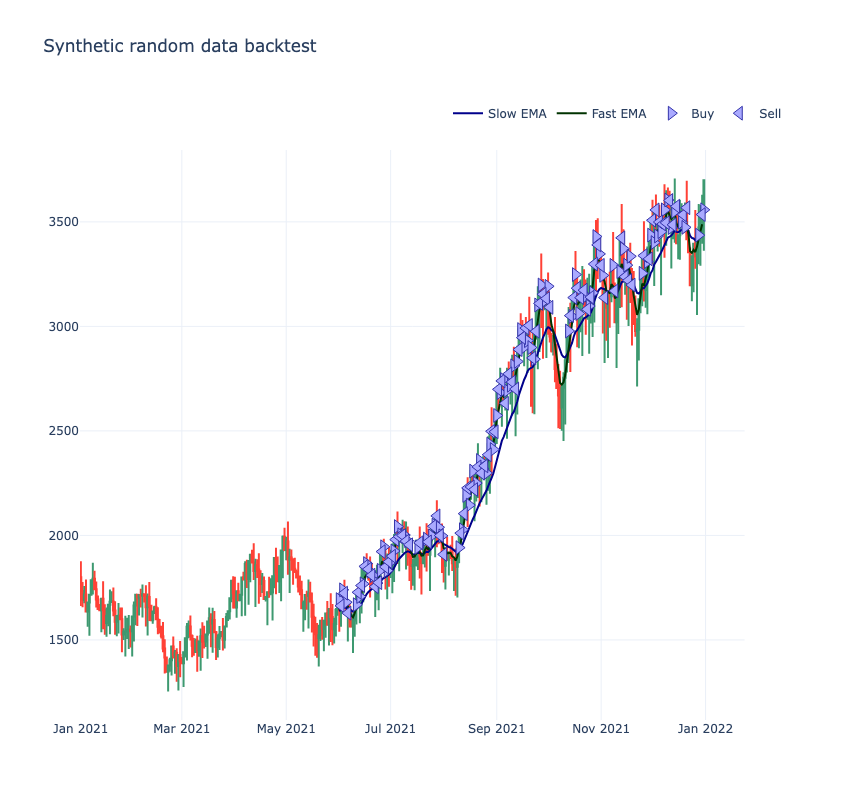

In [6]:
from tradeexecutor.visual.single_pair import visualise_single_pair

figure = visualise_single_pair(state, universe.universe.candles)

figure.show()

### Equity curve and drawdown

Visualise equity curve and related performnace over time.

- Returns

- Drawdown

- Daily returns

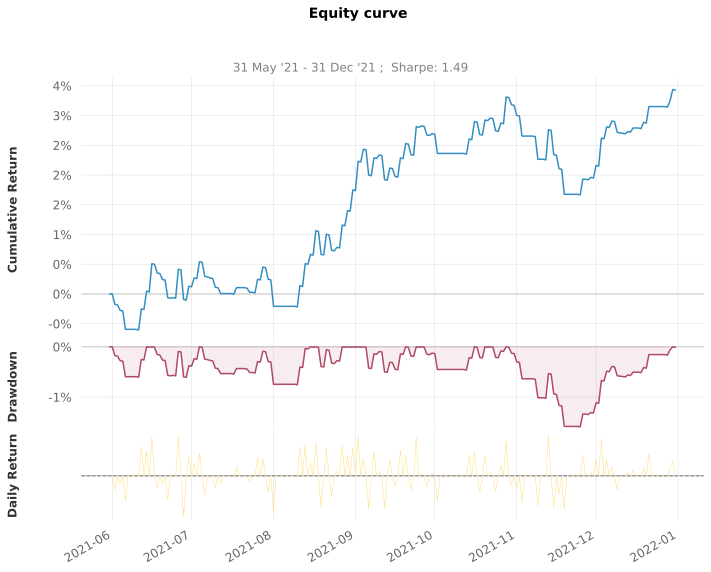

In [7]:
# Set Jupyter Notebook output mode parameters
# Used to avoid warnings
from tradeexecutor.backtest.notebook import setup_charting_and_output
setup_charting_and_output()

# Needed to improve the resolution of matplotlib chart used here
%config InlineBackend.figure_format = 'svg'

from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
visualise_equity_curve(returns)

### Returns monthly breakdown

- Monthly returns
- Best day/week/month/year

/usr/local/lib/python3.10/site-packages/quantstats/stats.py:968: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



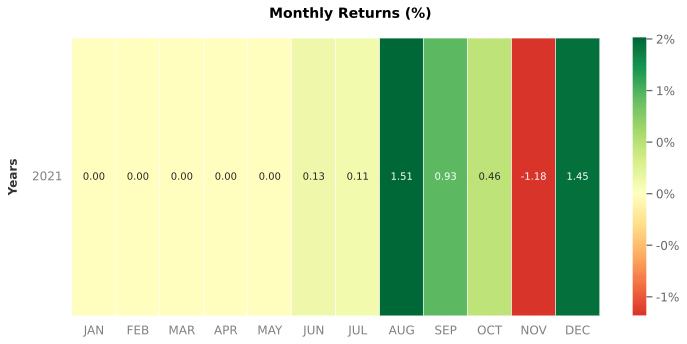

In [8]:
from tradeexecutor.visual.equity_curve import visualise_returns_over_time

visualise_returns_over_time(returns)

## Benchmarking the strategy performance

Here we benchmark the strategy performance against some baseline scenarios.

- Buy and hold US dollar
- Buy and hold the underlying trading pair base asset


In [9]:
close = universe.universe.candles.get_single_pair_data()["close"]

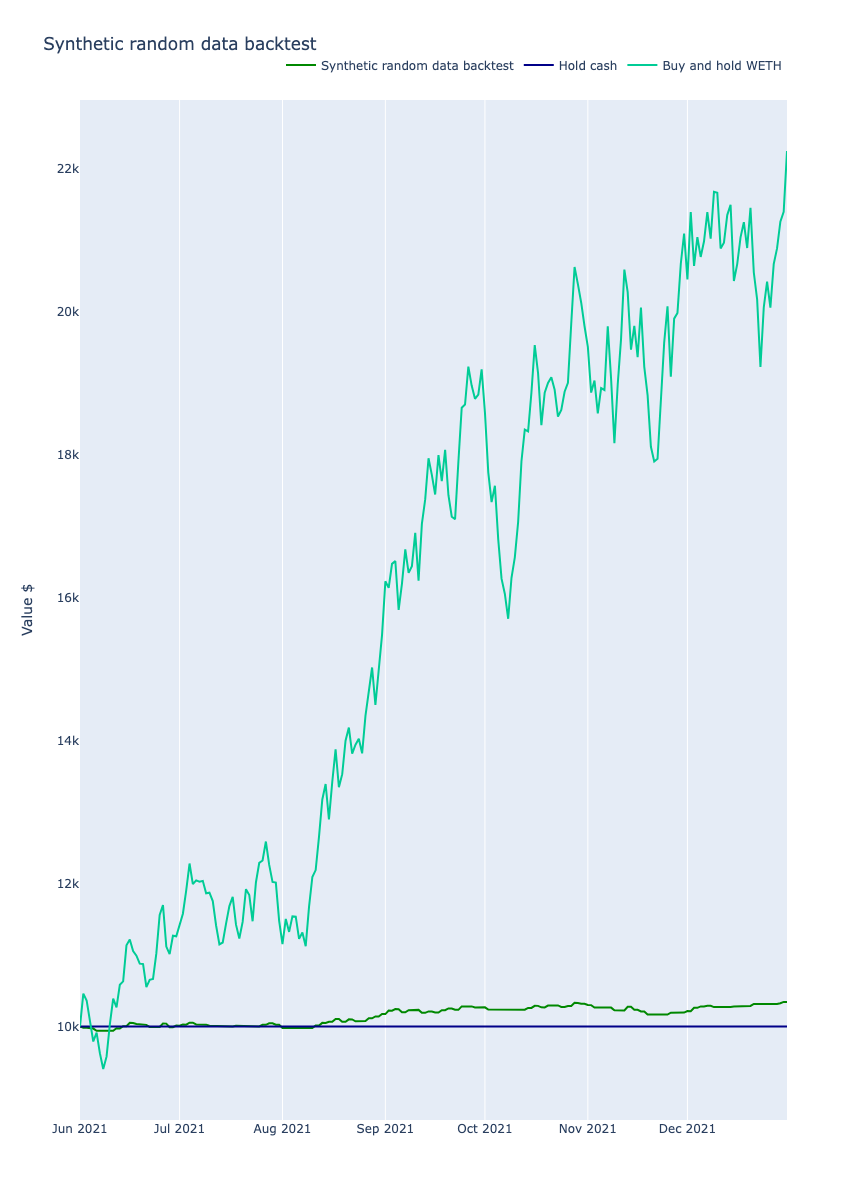

In [10]:
from tradeexecutor.visual.benchmark import visualise_benchmark

traded_pair = universe.universe.pairs.get_single()

fig = visualise_benchmark(
    state.name,
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_deposit(),
    buy_and_hold_asset_name=traded_pair.base_token_symbol,
    buy_and_hold_price_series=universe.universe.candles.get_single_pair_data()["close"],
)

fig.show()

## Analysing  the strategy success

Here we calculate statistics on how well the strategy performed.

- Won/lost trades
- Timeline of taken positions with color coding of trade performance


In [11]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)

### Strategy summary

Overview of strategy performance



In [12]:
from IPython.core.display_functions import display

summary = analysis.calculate_summary_statistics()

with pd.option_context("display.max_row", None):
    display(summary.to_dataframe())

0
Trading period length                      213 days
Return %                                      3.42%
Annualised return %                           5.85%
Cash at start                            $10,000.00
Value at end                             $10,341.60
Trade volume                            $165,852.44
Position win percent                         59.26%
Total positions                                  81
Won positions                                    48
Lost positions                                   33
Stop losses triggered                             0
Stop loss % of all                            0.00%
Stop loss % of lost                           0.00%
Winning stop losses                               0
Winning stop losses percent                       -
Losing stop losses                                0
Losing stop losses percent                        -
Take profits triggered                            0
Take profit % of all                          0.00%
Take profit % of won                          0.00%
Zero profit positions                             0
Positions open at the end                         1
Realised profit and loss                    $342.64
Portfolio unrealised value                $1,033.23
Extra returns on lending pool interest        $0.00
Cash left at the end                      $9,308.37
Average winning position profit %             2.36%
Average losing position loss %               -2.40%
Biggest winning position %                    4.85%
Biggest losing position %                    -5.06%
Average duration of winning positions        1 days
Average duration of losing positions         1 days
LP fees paid                                 $82.95
LP fees paid % of volume                      0.05%
Average position:                             0.42%
Median position:                              0.50%
Most consecutive wins                             6
Most consecutive losses                           4
Biggest realized risk                        -0.51%
Avg realised risk                            -0.24%
Max pullback of total capital                -1.07%
Max loss risk at opening of position         10.00%

### Performance metrics

Here is an example how to use Quantstats library to calculate the tearsheet metrics for the strategy with advanced metrics. The metrics include popular risk-adjusted return comparison metrics.

This includes metrics like:

- Sharpe
- Sortino
- Max drawdown

**Note:** These metrics are based on equity curve and returns. Analysis here does not go down to the level of an individual trade or a position. Any consecutive wins and losses are measured in days, not in trade or candle counts.

In [13]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.analysis.advanced_metrics import visualise_advanced_metrics, AdvancedMetricsMode

equity = calculate_equity_curve(state)
returns = calculate_returns(equity)
metrics = visualise_advanced_metrics(returns, mode=AdvancedMetricsMode.full)

with pd.option_context("display.max_row", None):
    display(metrics)

Strategy
Start Period               2021-06-01
End Period                 2021-12-31
Risk-Free Rate                   0.0%
Time in Market                  77.0%
Cumulative Return               3.43%
CAGR﹪                           5.94%
Sharpe                            1.8
Prob. Sharpe Ratio              91.8%
Smart Sharpe                     1.76
Sortino                          2.92
Smart Sortino                    2.86
Sortino/√2                       2.07
Smart Sortino/√2                 2.02
Omega                             1.4
Max Drawdown                   -1.59%
Longest DD Days                    62
Volatility (ann.)               3.23%
Calmar                           3.73
Skew                             0.31
Kurtosis                         1.93
Expected Daily                  0.02%
Expected Monthly                0.48%
Expected Yearly                 3.43%
Kelly Criterion                 8.65%
Risk of Ruin                     0.0%
Daily Value-at-Risk            -0.26%
Expected Shortfall (cVaR)      -0.26%
Max Consecutive Wins                2
Max Consecutive Losses              8
Gain/Pain Ratio                   0.4
Gain/Pain (1M)                   2.87
Payoff Ratio                     3.27
Profit Factor                     1.4
Common Sense Ratio               1.66
CPC Index                        1.38
Tail Ratio                       1.18
Outlier Win Ratio                4.09
Outlier Loss Ratio               5.61
MTD                             1.45%
3M                              0.74%
6M                              3.53%
YTD                             3.43%
1Y                              3.43%
3Y (ann.)                       5.94%
5Y (ann.)                       5.94%
10Y (ann.)                      5.94%
All-time (ann.)                 5.94%
Best Day                         0.5%
Worst Day                       -0.5%
Best Month                      1.51%
Worst Month                    -1.18%
Best Year                       3.43%
Worst Year                      3.43%
Avg. Drawdown                   -0.3%
Avg. Drawdown Days                 10
Recovery Factor                  2.15
Ulcer Index                      0.01
Serenity Index                    1.0
Avg. Up Month                   0.76%
Avg. Down Month                -1.18%
Win Days                       30.06%
Win Month                      85.71%
Win Quarter                    100.0%
Win Year                       100.0%

### Position and trade timeline

Display all positions and how much profit they made.



In [14]:
from tradeexecutor.analysis.trade_analyser import expand_timeline

timeline = analysis.create_timeline()

expanded_timeline, apply_styles = expand_timeline(
        universe.universe.exchanges,
        universe.universe.pairs,
        timeline)

# Do not truncate the row output
with pd.option_context("display.max_row", None):
    display(apply_styles(expanded_timeline))


## Finishing notes

Print out a line to signal the notebook finished the execution successfully.

In [15]:
print("All ok")

All ok
